# QuikieLit AI Model✍

## Importing libraries

In [1]:
import pandas as pd
import os
import string
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,precision_recall_fscore_support
import matplotlib.pyplot as plt
from spacy.lang.en import English

## Downloading Dataset 

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 7.52 MiB/s, done.
drive  pubmed-rct  sample_data


## Creating directory name for our train and test data

In [10]:
dir = "/content/pubmed-rct"
contents = os.listdir(dir)
my_data_file = dir + "/" + contents[2]
train_dir = my_data_file + "/train.txt"
valid_dir = my_data_file + "/dev.txt"
test_dir = my_data_file + "/test.txt"

In [11]:
contents

['PubMed_200k_RCT',
 '.git',
 'PubMed_20k_RCT_numbers_replaced_with_at_sign',
 'PubMed_200k_RCT_numbers_replaced_with_at_sign',
 'PubMed_20k_RCT',
 'README.md']

## Helper Functions

In [12]:
def read_text(dir):
  with open(dir) as f:
    return f.readlines()

In [13]:
def text_into_dictionary(text):
  Whole_Data = []
  for i in text:
    if i.startswith("###"):
      sentences = ""
    elif i.isspace():
      one_samples_at_a_time = sentences.splitlines()
      for number_of_line,lines in enumerate(one_samples_at_a_time):
        one_data = {}
        classes,text = lines.split("\t")
        one_data["Target"] = classes
        one_data["Text"] = text
        one_data["Line_Number"] = number_of_line
        one_data["Total_Number_Of_Lines"] = len(one_samples_at_a_time) - 1
        Whole_Data.append(one_data)
    else:
      sentences += i
  return Whole_Data

In [14]:
def get_score(pred,true):
  d = {}
  accuracy = accuracy_score(true,pred)*100
  p,r,f,_ = precision_recall_fscore_support(true,pred,average="weighted")
  d["Accuracy"] = accuracy
  d["precision"] = p
  d["recall"] = r
  d["f1_score"] = f
  return d

In [15]:
def split_chars(text):
  return " ".join(text)

## Getting the data into right format

In [16]:
train_text_file = read_text(train_dir)
valid_text_file = read_text(valid_dir)

In [17]:
train_data = text_into_dictionary(train_text_file)
valid_data = text_into_dictionary(valid_text_file)

In [18]:
train_df = pd.DataFrame(train_data)
valid_df = pd.DataFrame(valid_data)
train_df.head()

,Target,Text,Line_Number,Total_Number_Of_Lines
0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,A total of @ patients with primary knee OA wer...,1,11
2,METHODS,Outcome measures included pain reduction and i...,2,11
3,METHODS,Pain was assessed using the visual analog pain...,3,11
4,METHODS,Secondary outcome measures included the Wester...,4,11


## Encoding Labels

In [19]:
train_df.Target.to_numpy().reshape(-1,1)

array([['OBJECTIVE'],
       ['METHODS'],
       ['METHODS'],
       ...,
       ['RESULTS'],
       ['CONCLUSIONS'],
       ['CONCLUSIONS']], dtype=object)

In [20]:
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels = one_hot_encoder.fit_transform(train_df.Target.to_numpy().reshape(-1,1))
valid_labels = one_hot_encoder.transform(valid_df.Target.to_numpy().reshape(-1,1))
train_labels

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [21]:
label_encoder = LabelEncoder()
train_labels_l_e = label_encoder.fit_transform(train_df.Target.to_numpy().reshape(-1,1))
valid_labels_l_e = label_encoder.transform(valid_df.Target.to_numpy().reshape(-1,1))

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [22]:
classes = label_encoder.classes_
classes

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

## Creating Input for my model

In [23]:
train_text = train_df.Text.to_list()
valid_text = valid_df.Text.to_list()

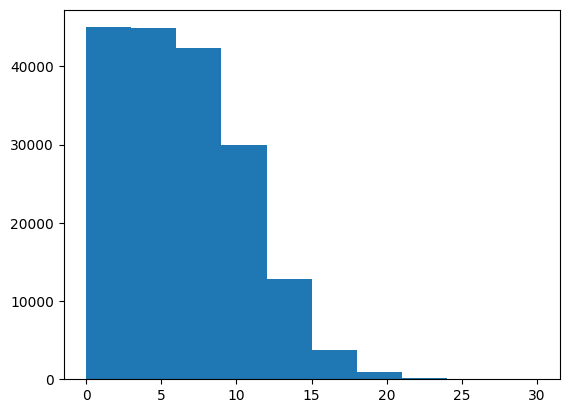

In [24]:
plt.hist(train_df.Line_Number);

In [25]:
np.percentile(train_df.Line_Number,95)

13.0

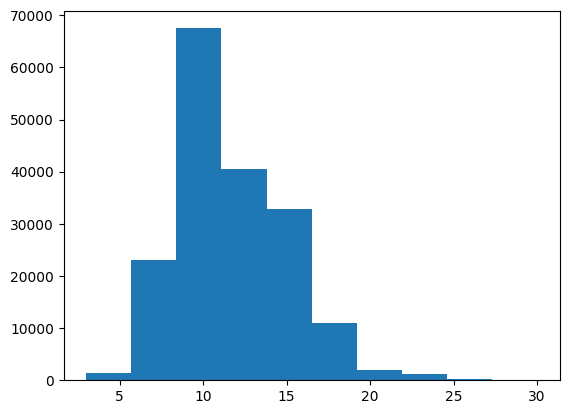

In [26]:
plt.hist(train_df.Total_Number_Of_Lines);

In [27]:
np.percentile(train_df.Total_Number_Of_Lines,95)

18.0

In [28]:
one_hot_encoder = OneHotEncoder(sparse=False,max_categories=15)
train_line_number = one_hot_encoder.fit_transform(train_df.Line_Number.to_numpy().reshape(-1,1))
valid_line_number = one_hot_encoder.transform(valid_df.Line_Number.to_numpy().reshape(-1,1));

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [29]:
train_total_number_of_lines = tf.one_hot(train_df.Total_Number_Of_Lines,depth=20)
valid_total_number_of_lines = tf.one_hot(valid_df.Total_Number_Of_Lines,depth=20)

In [30]:
train_chars = [split_chars(i)for i in train_text]
valid_chars = [split_chars(i)for i in valid_text]

In [31]:
number_of_words_count = [len(i)for i in train_text]
np.mean(number_of_words_count)

149.3662574983337

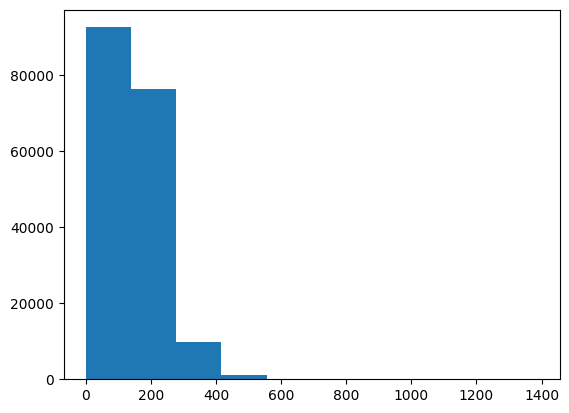

In [32]:
plt.hist(number_of_words_count);

In [33]:
np.percentile(number_of_words_count,95)

290.0

In [34]:
number_of_words = [len(i.split()) for i in train_text]
np.mean(number_of_words)

26.338269273494777

55.0

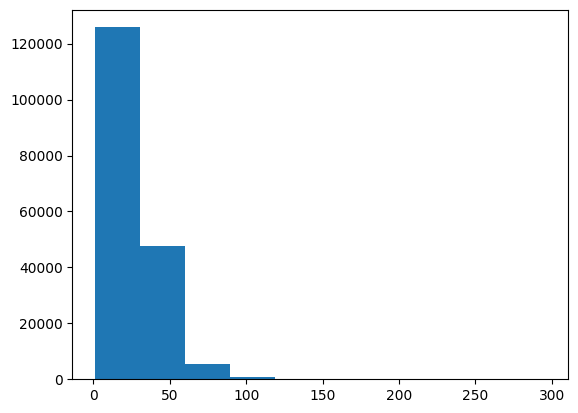

In [35]:
plt.hist(number_of_words);
np.percentile(number_of_words,95)

In [36]:
characters_in_keyboard = string.ascii_lowercase+string.digits+string.punctuation
len(characters_in_keyboard)

68

In [37]:
TV_Words = tf.keras.layers.TextVectorization(max_tokens = 68000, output_sequence_length = 55)
TV_Chars = tf.keras.layers.TextVectorization(max_tokens = len(characters_in_keyboard)+ 2 , output_sequence_length = 290)

In [38]:
TV_Words.adapt(train_text)
TV_Chars.adapt(train_chars)

In [39]:
total_vocabs_in_words = TV_Words.get_vocabulary()
len(total_vocabs_in_words)

64841

In [40]:
total_vocabs_in_chars = TV_Chars.get_vocabulary()
len(total_vocabs_in_chars)

28

In [41]:
E_Words = tf.keras.layers.Embedding(input_dim = len(total_vocabs_in_words), output_dim = 128, mask_zero=True)
E_Chars = tf.keras.layers.Embedding(input_dim = 2+len(characters_in_keyboard), output_dim = 25, mask_zero = False)

In [42]:
t = TV_Words("sriram")
print(t)
E_Words(t)

tf.Tensor(
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(55,), dtype=int64)


<tf.Tensor: shape=(55, 128), dtype=float32, numpy=
array([[ 0.03927812, -0.02015125,  0.02124644, ...,  0.03739426,
        -0.04718224, -0.00709689],
       [-0.01499218, -0.02042784,  0.03037491, ..., -0.03687303,
        -0.03187378,  0.03489863],
       [-0.01499218, -0.02042784,  0.03037491, ..., -0.03687303,
        -0.03187378,  0.03489863],
       ...,
       [-0.01499218, -0.02042784,  0.03037491, ..., -0.03687303,
        -0.03187378,  0.03489863],
       [-0.01499218, -0.02042784,  0.03037491, ..., -0.03687303,
        -0.03187378,  0.03489863],
       [-0.01499218, -0.02042784,  0.03037491, ..., -0.03687303,
        -0.03187378,  0.03489863]], dtype=float32)>

In [43]:
t = TV_Chars("s r i r a m")
print(t)
E_Chars(t)

tf.Tensor(
[ 9  8  4  8  5 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0], shape=(290,), dtype=int64)


<tf.Tensor: shape=(290, 25), dtype=float32, numpy=
array([[ 3.79736163e-02, -4.78371158e-02,  3.80282886e-02, ...,
         4.52396758e-02,  2.14766152e-02,  3.44495811e-02],
       [ 1.46844275e-02,  1.63428485e-05,  3.61515321e-02, ...,
        -2.18239427e-02,  3.17705981e-02,  4.59164120e-02],
       [-2.22570430e-02, -2.74745356e-02,  1.95239447e-02, ...,
        -4.51515801e-02,  2.76885293e-02, -3.87657508e-02],
       ...,
       [ 2.73257010e-02,  4.55189086e-02,  4.63344790e-02, ...,
         5.91223314e-03, -4.12850268e-02, -3.92700210e-02],
       [ 2.73257010e-02,  4.55189086e-02,  4.63344790e-02, ...,
         5.91223314e-03, -4.12850268e-02, -3.92700210e-02],
       [ 2.73257010e-02,  4.55189086e-02,  4.63344790e-02, ...,
         5.91223314e-03, -4.12850268e-02, -3.92700210e-02]], dtype=float32)>

## Creating Model

In [44]:
model_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
Universal_Sentence_Encoder_Keras_Layer = hub.KerasLayer(model_url,trainable=False)

In [45]:
#Transfer_Learning_Model
T_L_I = tf.keras.layers.Input(shape=[],dtype=tf.string)
Embedding = Universal_Sentence_Encoder_Keras_Layer(T_L_I)
output = tf.keras.layers.Dense(len(classes),activation="softmax",name="Transfer_Learning_Activation")(Embedding)
T_L_M = tf.keras.Model(inputs=T_L_I,outputs=output,name="Transfer_Learning_Model")

#Word_Embedding_Model
W_E_I = tf.keras.layers.Input(shape=(1,),dtype=tf.string)
T_V_W = TV_Words(W_E_I)
E_W = E_Words(T_V_W)
dense = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(25),name="BiDirectionalLSTM_Words")(E_W)
output = tf.keras.layers.Dense(len(classes),activation="softmax")(dense)
W_E_M = tf.keras.Model(inputs=W_E_I,outputs=output,name="Word_Embedding_Model")

#Chars_Embedding_Model
C_E_I = tf.keras.layers.Input(shape=(1,),dtype=tf.string)
T_V_C = TV_Chars(C_E_I)
E_C = E_Chars(T_V_C)
dense = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(25),name="BiDirectionalLSTM_Chars")(E_C)
output = tf.keras.layers.Dense(len(classes),activation="softmax")(dense)
C_E_M = tf.keras.Model(inputs=C_E_I,outputs = output,name="Char_Embedding_Model")

#Line_Number_Model
L_N_I = tf.keras.layers.Input(shape=(15,),dtype=tf.float32)
dense = tf.keras.layers.Dense(128,activation="relu")(L_N_I)
output = tf.keras.layers.Dense(len(classes),activation="softmax",name="Line_Number_Activation")(dense)
L_N_M = tf.keras.Model(L_N_I,output,name="Line_Number_Model")

#Total_Number_Lines_Model
T_N_I = tf.keras.layers.Input(shape=(20,),dtype=tf.float32)
dense = tf.keras.layers.Dense(128,activation="relu")(T_N_I)
output = tf.keras.layers.Dense(len(classes),activation="softmax",name="Total_Number_Of_Lines_Activation")(dense)
T_N_M = tf.keras.Model(T_N_I,output,name="Total_Number_Of_Lines_Model")

#Combining EveryInput
Char_Word_Transfer_Learing_Concatenated = tf.keras.layers.Concatenate(name="Transfer_Learning_Char_Word_Concatenated")(
    [T_L_M.output,
     W_E_M.output,
     C_E_M.output])
local_dense = tf.keras.layers.Dense(128,activation="relu")(Char_Word_Transfer_Learing_Concatenated)
local_drop_out = tf.keras.layers.Dropout(0.5)(local_dense)

Line_Number_Total_Number_Concatenated = tf.keras.layers.Concatenate(name="Line_Number_Total_Number_Concatenated")(
    [L_N_M.output,T_N_M.output,local_drop_out]
)
dense = tf.keras.layers.Dense(128,activation="relu")(Line_Number_Total_Number_Concatenated)
Output = tf.keras.layers.Dense(len(classes),activation="softmax")(dense)

#Final Model
Model = tf.keras.Model(inputs = [T_L_I,
                                 W_E_I,
                                 C_E_I,
                                 L_N_I,
                                 T_N_I],outputs=Output)

Model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics="accuracy")
Model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 55)          0           ['input_2[0][0]']                
 ization)                                                                                         
                                                                                                  
 text_vectorization_1 (TextVect  (None, 290)         0           ['input_3[0][0]']            

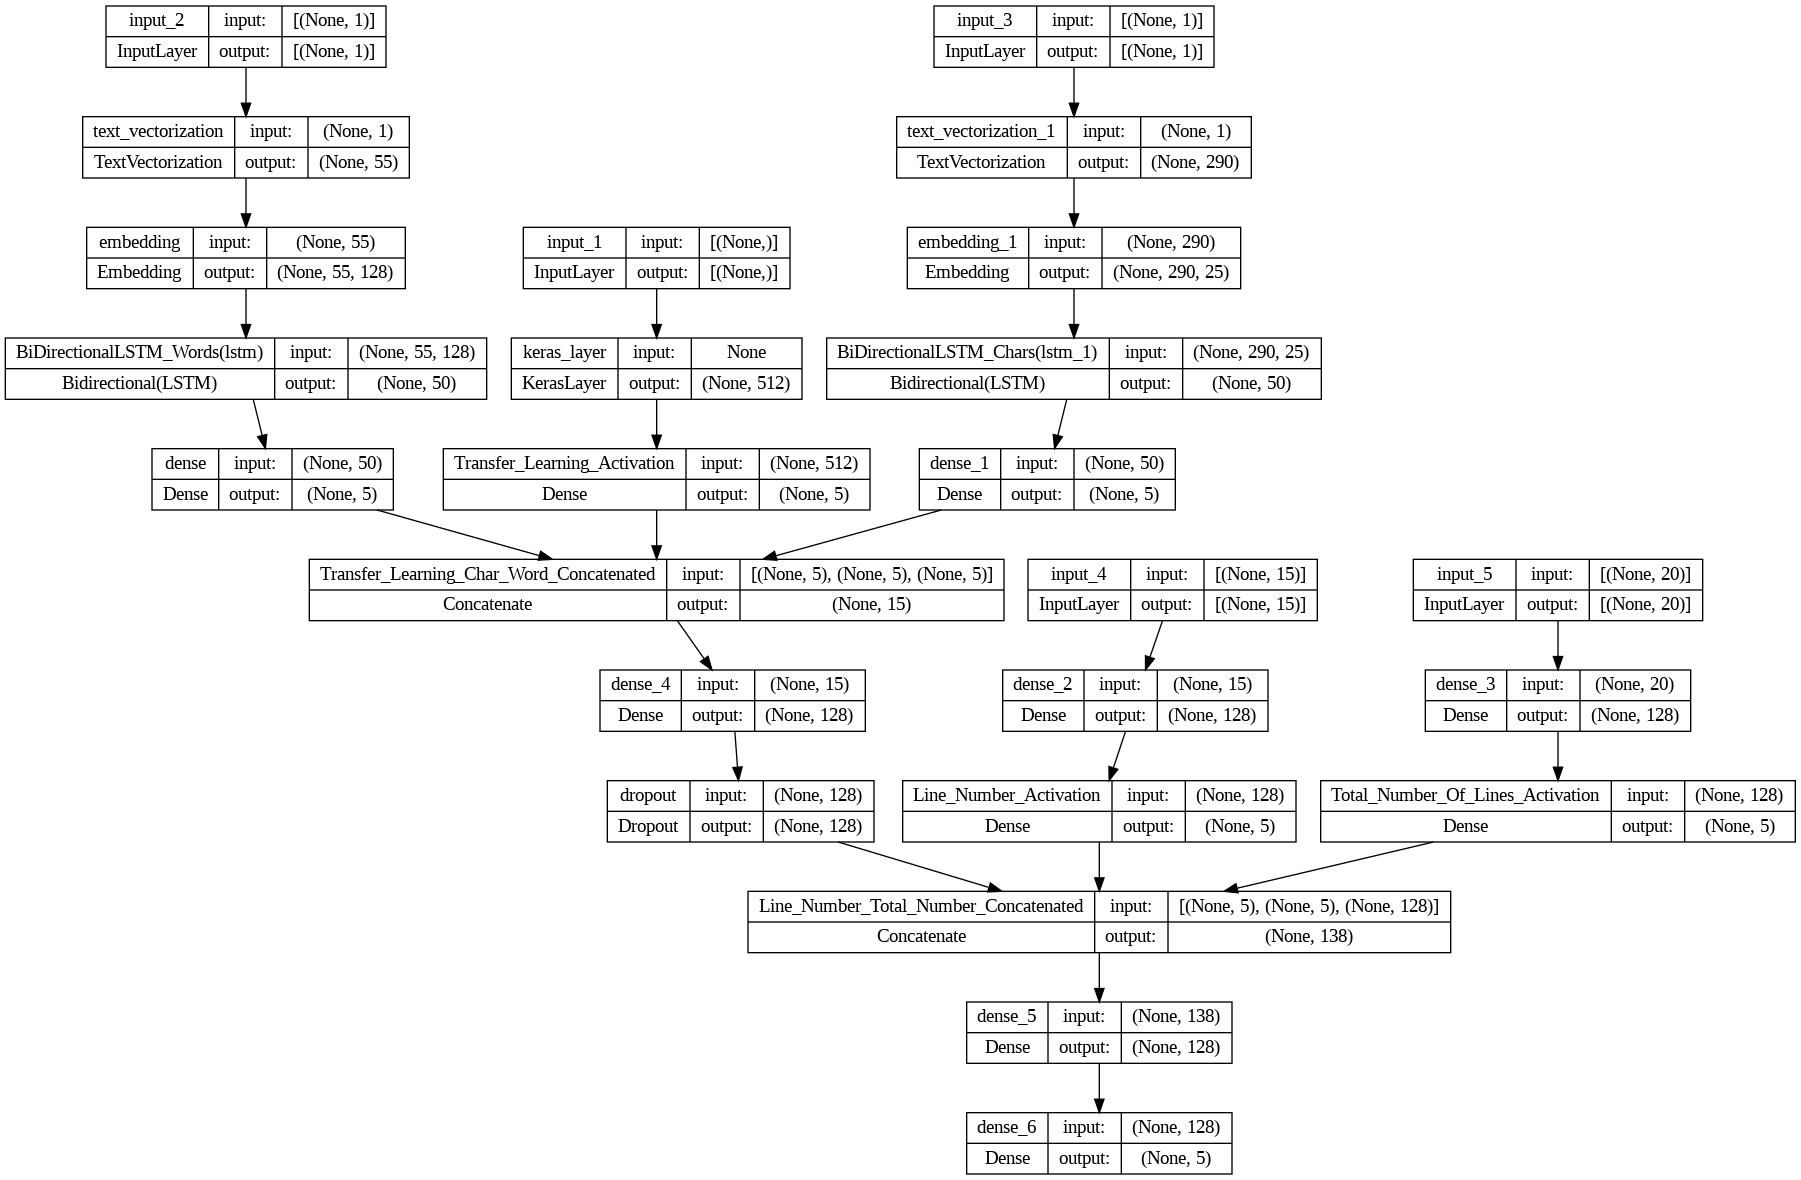

In [46]:
plot_model(Model,show_shapes=True)

## Creating Input

In [47]:
Training_Data = tf.data.Dataset.from_tensor_slices(((train_text,
                                                     train_text,
                                                     train_chars,
                                                     train_line_number,
                                                     train_total_number_of_lines),
                                                     train_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

Validation_Data = tf.data.Dataset.from_tensor_slices(((valid_text,
                                                       valid_text,
                                                       valid_chars,
                                                       valid_line_number,
                                                       valid_total_number_of_lines),
                                                      valid_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

## Training The Model

In [48]:
# Model_History = Model.fit(Training_Data,epochs=10,steps_per_epoch = int(0.1*len(Training_Data)),
#                           validation_data = Validation_Data,validation_steps=int(0.1*len(Validation_Data)))

## Evaluating 

In [49]:
# Model_Pred = Model.predict(Validation_Data)
# Model_Pred

In [50]:
# Model_Pred.shape

In [51]:
# Model_Prediction = tf.argmax(Model_Pred,axis=1)
# get_score(Model_Prediction,valid_labels_l_e)

## Saving the Model

In [52]:
# Model.save("QuickieLit")

In [53]:
# !cp QuickieLit -r /content/drive/MyDrive/tensorflow_course

## Loading The Model

download this model if you want to load the same model i had

https://drive.google.com/drive/folders/12C3GaHP_nIcYuvrtRit4NsJEDUPwkYC4?usp=sharing

In [54]:
# if you want to load the saved model from the google drive above 
Loaded_Model = tf.keras.models.load_model("QuickieLit",
                                          custom_objects={"KerasLayer":hub.KerasLayer})
#if you are trained your model in this notebook
# Loaded_Model = Model

In [55]:
Loaded_Model.evaluate(Validation_Data) 

945/945 [==============================] - 54s 54ms/step - loss: 0.3079 - accuracy: 0.8830


[0.3078823685646057, 0.8829935193061829]

## Test Data

In [76]:
test_text_file = read_text(test_dir)
test_data = text_into_dictionary(test_text_file)
test_df = pd.DataFrame(test_data)
one_hot_encoder = OneHotEncoder(sparse=False,handle_unknown='ignore')
train_labels = one_hot_encoder.fit(train_df.Target.to_numpy().reshape(-1,1))
test_labels = one_hot_encoder.transform(test_df.Target.to_numpy().reshape(-1,1))
test_labels_l_e = label_encoder.transform(test_df.Target.to_numpy().reshape(-1,1))
test_text = test_df.Text.to_list()
test_line_number = tf.one_hot(test_df.Line_Number,depth=15)
test_total_number_of_lines = tf.one_hot(test_df.Total_Number_Of_Lines,depth=20)
test_chars = [split_chars(i)for i in test_text]

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [72]:
Test_Data = tf.data.Dataset.from_tensor_slices(((test_text,
                                                       test_text,
                                                       test_chars,
                                                       test_line_number,
                                                       test_total_number_of_lines),
                                                      test_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [73]:
Test_Prediction = Loaded_Model.predict(Test_Data)
Test_Prediction

942/942 [==============================] - 83s 85ms/step


array([[4.2054728e-01, 8.2674436e-04, 6.5750659e-02, 5.1047188e-01,
        2.4034900e-03],
       [9.5130550e-03, 6.3129002e-04, 9.4564772e-01, 1.6492592e-02,
        2.7715379e-02],
       [1.2438351e-03, 9.7480683e-05, 9.6921724e-01, 2.3065933e-03,
        2.7134821e-02],
       ...,
       [1.8106795e-04, 2.5342908e-05, 2.5844121e-02, 4.0869621e-05,
        9.7390860e-01],
       [1.8179512e-03, 3.9911309e-05, 4.3463778e-01, 6.5015448e-04,
        5.6285423e-01],
       [1.6550483e-01, 4.7288911e-04, 4.0927741e-01, 2.8467745e-02,
        3.9627707e-01]], dtype=float32)

In [74]:
Test_Pred_Labels = tf.argmax(Test_Prediction,axis=1)

In [77]:
get_score(Test_Pred_Labels,test_labels_l_e)

{'Accuracy': 86.58702505392401,
 'precision': 0.8683074877091121,
 'recall': 0.86587025053924,
 'f1_score': 0.8643831768333328}

## Single Test

In [59]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

--2023-04-17 15:46:56--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2023-04-17 15:46:56 (85.2 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



In [60]:
import json
with open("skimlit_example_abstracts.json","r")as f:
  example_abstract = json.load(f)
example_abstract

[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [61]:
abstracts = pd.DataFrame(example_abstract)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [62]:
nlp = English()
nlp.add_pipe("sentencizer")
doc = nlp(abstracts["abstract"][0])
doc

This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.

In [63]:
abstract_line = [str(sent)for sent in list(doc.sents)]
abstract_line

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [64]:
total_line_number = len(abstract_line)
sample_text = []
for i,lines in enumerate(abstract_line):
  dic = {}
  dic["text"] = lines
  dic["line_number"] = i
  dic["total_line_number"] = total_line_number-1
  sample_text.append(dic)
sample_text

[{'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'line_number': 0,
  'total_line_number': 7},
 {'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'line_number': 1,
  'total_line_number': 7},
 {'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'line_number': 2,
  'total_line_number': 7},
 {'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'line_number': 3,
  'total_line_number': 7},
 {'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'line_number': 4,
  'total_line_number': 7},
 {'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'line_number': 5,

In [65]:
test_abstract_lines_number = [line["line_number"]for line in sample_text]
test_abstract_lines_number_one_hot = tf.one_hot(test_abstract_lines_number,depth=15)
test_abstract_lines_number_one_hot

<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [66]:
test_abstract_total_lines = [line["total_line_number"]for line in sample_text]
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines,depth=20)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(8, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [67]:
abstract_chars = [split_chars(text)for text in abstract_line]
abstract_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

In [68]:
abstract_test = Loaded_Model.predict(x=(tf.constant(abstract_line),tf.constant(abstract_line),tf.constant(abstract_chars),test_abstract_lines_number_one_hot,test_abstract_total_lines_one_hot))
abstract_test_le = tf.argmax(abstract_test,axis=1)
abstract_test_le

1/1 [==============================] - 3s 3s/step


<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 4, 2, 4, 4])>

In [69]:
abstract_class = [label_encoder.classes_[i]for i in abstract_test_le]
abstract_class

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS']

In [70]:
pred_probs = tf.reduce_max(abstract_test,axis=1)
pred_probs

<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([0.6838346 , 0.9876225 , 0.9479301 , 0.51420957, 0.98689795,
       0.83628875, 0.930896  , 0.9432902 ], dtype=float32)>

In [71]:
for i,text in enumerate(abstract_line):
  print(f"the predicted class is : {abstract_class[i]} {pred_probs[i]*100:.2f}%")
  print(f"the text is : {text}")

the predicted class is : OBJECTIVE 68.38%
the text is : This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
the predicted class is : METHODS 98.76%
the text is : Participants were randomly assigned to treatment or wait-list conditions.
the predicted class is : METHODS 94.79%
the text is : Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
the predicted class is : METHODS 51.42%
the text is : A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
the predicted class is : RESULTS 98.69%
the text is : Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
the predicted class is : METHODS 83.63%
the text is : Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
the pr